In [1]:
import torch
import matplotlib.pyplot as plt

import sys
sys.path.append('../../Steerable/')
import Steerable.nn as snn
from Steerable.utils import FocalLoss, Metrics, rotate_image2D, rotate_image3D

In [2]:
class Model2D(torch.nn.Module):
    def __init__(self) -> None:
        super(Model2D, self).__init__()
        
        self.num_classes = 2
        n_angle = 1000
        freq_cutoff = 4
        self.convolution_stem = torch.nn.Sequential(
            snn.SE2ConvType1(1,2,3, freq_cutoff, n_angle=n_angle, padding='same'),
            snn.SE2NormNonLinearity(2, freq_cutoff),
            snn.SE2BatchNorm(),
            snn.SE2ConvType2(2,2,3, freq_cutoff, n_angle=n_angle, padding='same'),
            snn.SE2BatchNorm(),
            snn.SE2AvgPool(2)
        )

        self.encoder_decoder = torch.nn.Sequential(
            snn.SE2TransformerEncoder(2, 1, freq_cutoff, 1, add_pos_enc=True),
            snn.SE2TransformerDecoder(2, 1, freq_cutoff, self.num_classes, 1, add_pos_enc=True)
        )
        
        self.head = torch.nn.Sequential(
            snn.SE2ConvType2(2,2,3, freq_cutoff, n_angle=n_angle, padding='same'),
            snn.SE2NormNonLinearity(2, freq_cutoff),
            snn.SE2BatchNorm(),
            snn.SE2ConvType2(2,2,3, freq_cutoff, n_angle=n_angle, padding='same'),
            snn.SE2BatchNorm(),
        )
        
        self.embed = snn.SE2ClassEmbeddings(2, 2, freq_cutoff)   
        
        
    def forward(self, x):
        x_shape = x.shape
        x = x.type(torch.cfloat)
        
        x = self.convolution_stem(x)         
        x, classes = self.encoder_decoder(x)

        # Interpolation
        x = torch.nn.functional.interpolate(x.real, size=(x.shape[-3], *x_shape[-2:]), mode="trilinear") + \
            1j*torch.nn.functional.interpolate(x.imag, size=(x.shape[-3], *x_shape[-2:]), mode="trilinear")
        
        x = self.embed(x, classes).abs()
        
        return x


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model2D = Model2D().to(device)
criterion = FocalLoss()
metrics = Metrics(model2D.num_classes)

8.940696716308594e-08
0.0


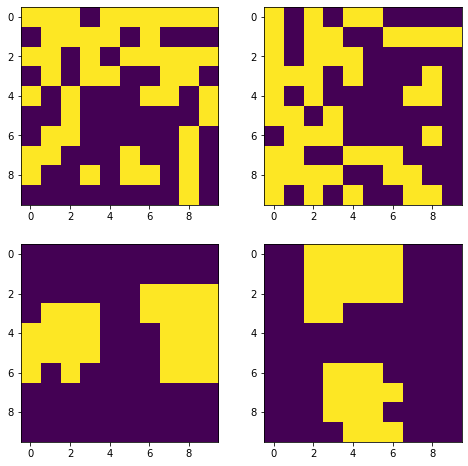

In [3]:
res = 10
batch_size = 1

with torch.no_grad():
    inputs = torch.randn(batch_size, 1, *[res]*2, device=device)
    targets = torch.randint(0, model2D.num_classes, (batch_size, *[res]*2), device=device)
    outputs = model2D(inputs)
    loss = criterion(outputs, targets).item()
    preds = torch.argmax(outputs, dim=1)
    dice = metrics.micro(preds, targets)

    inputs_rot = rotate_image2D(inputs.cpu(), 90).to(device)
    targets_rot = rotate_image2D(targets.unsqueeze(1).cpu(), 90, order=0).squeeze(1).to(device)
        
    outputs_rot = model2D(inputs_rot)
    loss_rot = criterion(outputs_rot, targets_rot).item()
    preds_rot = torch.argmax(outputs_rot, dim=1)
    dice_rot = metrics.micro(preds_rot, targets_rot)

    print(abs(loss - loss_rot))
    print(abs(dice - dice_rot))
    
    fig, ax = plt.subplots(2,2)
    fig.set_size_inches(8,8)
    ax[0,0].imshow(targets[0].cpu())
    ax[0,1].imshow(targets_rot[0].cpu())
    ax[1,0].imshow(preds[0].cpu())
    ax[1,1].imshow(preds_rot[0].cpu())

    plt.show()

In [10]:
a = torch.randn(1,1,10,10, device=device)
b = model2D(a)
torch.save(model2D.state_dict(), "state.pkl")
model2D = Model2D().to(device)
model2D(a)
model2D.load_state_dict(torch.load('state.pkl'))
c = model2D(a)

(b-c).abs().max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

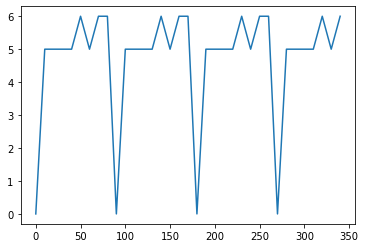

In [19]:
res = 10
batch_size = 10
model = Model2D().to(device)
degrees = torch.arange(0, 350, 10)
diff = torch.zeros_like(degrees)
with torch.no_grad():
    inputs = torch.randn(batch_size, 1, *[res]*2, device=device)
    outputs = model(inputs).cpu()
    for i, degree in enumerate(degrees):
        inputs_rot = rotate_image2D(inputs.cpu(), degree).to(device)
        outputs_rot = model(inputs_rot).flatten(1).cpu()
        rot_outputs = rotate_image2D(outputs, degree).flatten(1)
        diff[i] = torch.max(torch.abs(rot_outputs - outputs_rot), dim=1)[0].mean()
        
plt.plot(degrees, diff)

In [4]:
class Model3D(torch.nn.Module):
    def __init__(self) -> None:
        super(Model3D, self).__init__()
        
        self.num_classes = 2
        n_angle = 40
        self.convolution_stem = torch.nn.Sequential(
            snn.SE3Conv(1,[2,2],3, n_angle=n_angle, padding='same'),
            snn.SE3NormNonLinearity([2,2]),
            snn.SE3BatchNorm(),
            snn.SE3Conv([2,2], [2,2],3, n_angle=n_angle, padding='same'),
            snn.SE3BatchNorm(),
            snn.SE3AvgPool(2)
        )

        self.encoder_decoder = torch.nn.Sequential(
            snn.SE3TransformerEncoder([2,2], 1, 1, add_pos_enc=True),
            snn.SE3TransformerDecoder([2,2], 1, self.num_classes, 1, add_pos_enc=True)
        )
        
        self.head = torch.nn.Sequential(
            snn.SE3Conv([2,2],[2,2],3, n_angle=n_angle, padding='same'),
            snn.SE3NormNonLinearity([2,2]),
            snn.SE3BatchNorm(),
            snn.SE3Conv([2,2],[2,2],3, n_angle=n_angle, padding='same'),
            snn.SE3BatchNorm(),
        )
        
        self.embed = snn.SE3ClassEmbedings([2,2], [2,2])   
        
        
    def forward(self, x):
        x_shape = x.shape
        x = x.type(torch.cfloat)
        
        x = self.convolution_stem(x)         
        x, classes = self.encoder_decoder(x)

        # Interpolation
        x, channels = snn.merge_channel_dim(x)
        x = torch.nn.functional.interpolate(x.real, size=x_shape[-3:], mode="trilinear") + \
                  1j * torch.nn.functional.interpolate(x.imag, size=x_shape[-3:], mode="trilinear")
        x = snn.split_channel_dim(x, channels=channels)
        
        x = self.embed(x, classes).abs()
        
        return x


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model3D = Model3D().to(device)
criterion = FocalLoss()
metrics = Metrics(model3D.num_classes)

In [5]:
res = 10
batch_size = 1

with torch.no_grad():
    inputs = torch.randn(batch_size, 1, *[res]*3, device=device)
    targets = torch.randint(0, model3D.num_classes, (batch_size, *[res]*3), device=device)
    outputs = model3D(inputs)
    
    loss = criterion(outputs, targets).item()
    preds = torch.argmax(outputs, dim=1)
    dice = metrics.micro(preds, targets)

    inputs_rot = rotate_image3D(inputs.cpu(), [90,0,90]).to(device)
    targets_rot = rotate_image3D(targets.unsqueeze(1).cpu(), [90,0,90], order=0).squeeze(1).to(device)
    outputs_rot = model3D(inputs_rot)
    
    loss_rot = criterion(outputs_rot, targets_rot).item()
    preds_rot = torch.argmax(outputs_rot, dim=1)
    dice_rot = metrics.micro(preds_rot, targets_rot)

    print(abs(loss - loss_rot))
    print(abs(dice - dice_rot))

1.4901161193847656e-08
0.0
